In [3]:
# Load pickled data
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

training_file = "C:/Users/LAPTOP64/Desktop/trafiic-signs-data/train.p"
#validation_file="C:/Users/LAPTOP64/Desktop/trafiic-signs-data//valid.p"
testing_file = "C:/Users/LAPTOP64/Desktop/trafiic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
#with open(validation_file, mode='rb') as f:
#   valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
#X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [1]:
#here
X_train[0][0]


NameError: name 'X_train' is not defined

In [3]:
import numpy as np

n_train = X_train.shape[0]
#n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
#print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


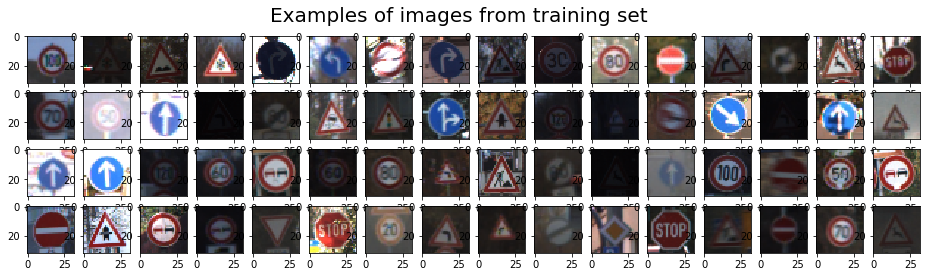

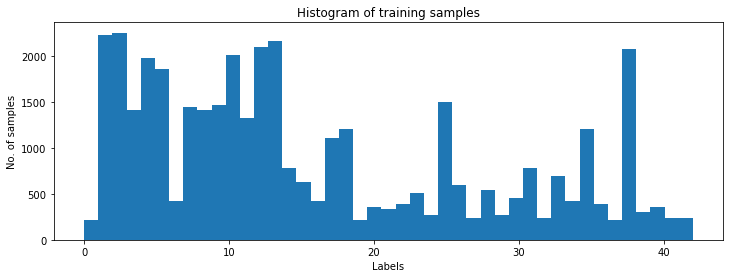

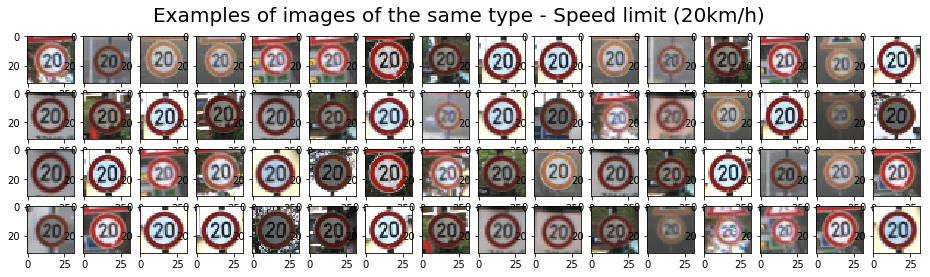

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random 

# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')

def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)
 
    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
       
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)
        
draw_images_examples(X_train, 16, 4, 'Examples of images from training set')
    

fig = plt.figure(figsize=(12,4))
n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Histogram of training samples')

X_train_one_label = X_train[np.where(y_train==0)]
draw_images_examples(X_train_one_label, 16, 4, 'Examples of images of the same type - Speed limit (20km/h)')

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [04:16<00:00,  5.97s/it]


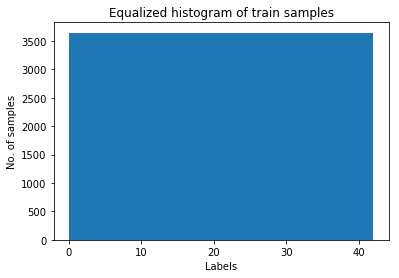

Train set increased from 39209 to 156692


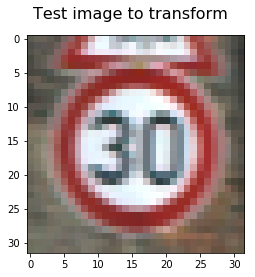

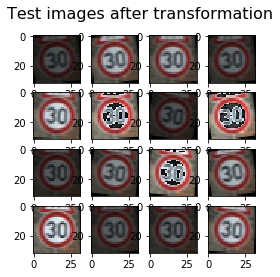

In [8]:
from tqdm import tqdm
from scipy import ndimage
import cv2 

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img):    
    ang_range = 25
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))    
    img = augment_brightness_camera_images(img)
    
    return img

def get_random_image_of_given_label(images_set, labels_set, label):
    image_indexes = np.where(labels_set == label)
    rand_index = random.randint(0, np.bincount(labels_set)[label] - 1)
    return images_set[image_indexes][rand_index]

def equalize_samples_set(X_set, y_set):
    labels_count_arr = np.bincount(y_set)
    labels_bins = np.arange(len(labels_count_arr))
    
    ind = 0    
   
    for label in tqdm(labels_bins):        
        labels_no_to_add =  int(np.mean(labels_count_arr)) * 4 - labels_count_arr[label]
        
        ind = ind + 1
        X_temp = []
        y_temp = []
        
        for num in range(labels_no_to_add):      
            rand_image = get_random_image_of_given_label(X_set, y_set, label)
            X_temp.append(transform_image(rand_image))
            y_temp.append(label)            
   
        X_set = np.append(X_set, np.array(X_temp), axis=0)
        y_set = np.append(y_set, np.array(y_temp), axis=0)
        
    return X_set, y_set


X_train, y_train = equalize_samples_set(X_train, y_train)

n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Equalized histogram of train samples')
plt.show()

print("Train set increased from {} to {}".format(n_train,X_train.shape[0]))

fig=plt.figure()
fig.suptitle('Test image to transform', fontsize=16)
plt.imshow(X_train[1000])

grid_len = 4
fig=plt.figure(figsize=(grid_len,grid_len))
fig.suptitle('Test images after transformation', fontsize=16)
 
for i in range(1,grid_len*grid_len+1):
    image = transform_image(X_train[1000])
    plt.subplot(grid_len,grid_len,i)
    plt.imshow(image)

100%|█████████████████████████████████████████████████████████████████████████| 12630/12630 [00:00<00:00, 24862.57it/s]


Sample image dimension BEFORE processing: (32, 32, 3)
Sample image dimension AFTER processing: (32, 32, 1)


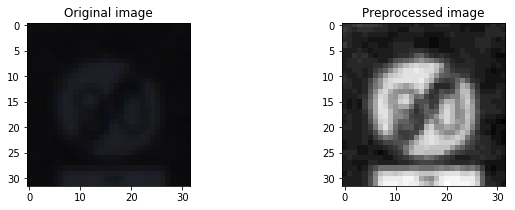

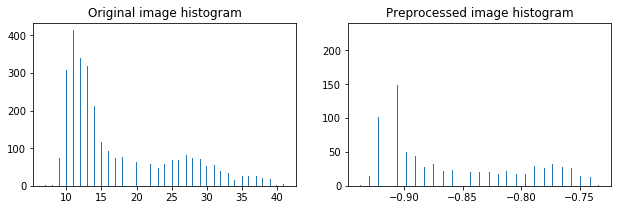

In [9]:
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,None]

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return img

from tqdm import tqdm
def preprocess_batch(images):
    imgs = np.zeros(shape=images.shape)
    processed_image_depth = preprocess_image(images[0]).shape[2]
    imgs = imgs[:,:,:,0:processed_image_depth]
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess_image(images[i])        
    return imgs

X_train_processed = preprocess_batch(X_train)
#X_valid_processed = preprocess_batch(X_valid)
X_test_processed = preprocess_batch(X_test)

no_test_image = 10000

sample_image = X_train[no_test_image]
sample_image_processed = grayscale(X_train[no_test_image])
fig=plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image")
plt.imshow(sample_image)
sub=plt.subplot(132)
sub.set_title("Preprocessed image")
plt.imshow(sample_image_processed.squeeze(), cmap='gray')

print("Sample image dimension BEFORE processing: {}".format(sample_image.shape))
print("Sample image dimension AFTER processing: {}".format(sample_image_processed.shape))

image_depth = X_train_processed.shape[3]

sample_image = X_train[no_test_image]
dim1 = sample_image.shape[0]
dim2 = sample_image.shape[1]
dim3 = sample_image.shape[2]
sample_image_reshaped = np.reshape(sample_image, dim1*dim2*dim3)
plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image histogram")
n, bins, patches = plt.hist(sample_image_reshaped, 255)

sample_image_processed = X_train_processed[no_test_image]
dim1 = sample_image_processed.shape[0]
dim2 = sample_image_processed.shape[1]
dim3 = sample_image_processed.shape[2]
sample_image_processed_reshaped = np.reshape(sample_image_processed, dim1*dim2*dim3)
sub=plt.subplot(132)
sub.set_title("Preprocessed image histogram")
n, bins, patches = plt.hist(sample_image_processed_reshaped,255)

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 200
BATCH_SIZE = 128

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
        
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, image_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.003

logits = LeNet(x)

varss = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in varss
                    if '_b' not in v.name ]) * 0.0001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + lossL2
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

EPOCH; 1.000; Loss; 0.13567
EPOCH; 2.000; Loss; 0.11525
EPOCH; 3.000; Loss; 0.09065
EPOCH; 4.000; Loss; 0.07973
EPOCH; 5.000; Loss; 0.50444
EPOCH; 6.000; Loss; 0.19492
EPOCH; 7.000; Loss; 0.10707
EPOCH; 8.000; Loss; 0.08594
EPOCH; 9.000; Loss; 0.14074
EPOCH; 10.000; Loss; 0.20197
EPOCH; 11.000; Loss; 0.21855
EPOCH; 12.000; Loss; 0.09273
EPOCH; 13.000; Loss; 0.10313
EPOCH; 14.000; Loss; 0.08617
EPOCH; 15.000; Loss; 0.08694
EPOCH; 16.000; Loss; 0.57044
EPOCH; 17.000; Loss; 0.14335
EPOCH; 18.000; Loss; 0.10265
EPOCH; 19.000; Loss; 0.25125
EPOCH; 20.000; Loss; 0.08362
EPOCH; 21.000; Loss; 0.08683
EPOCH; 22.000; Loss; 0.14433
EPOCH; 23.000; Loss; 0.08435
EPOCH; 24.000; Loss; 0.08617
EPOCH; 25.000; Loss; 0.26003
EPOCH; 26.000; Loss; 0.08060
EPOCH; 27.000; Loss; 0.11390
EPOCH; 28.000; Loss; 0.08195
EPOCH; 29.000; Loss; 0.11382
EPOCH; 30.000; Loss; 0.08156
EPOCH; 31.000; Loss; 0.08042
EPOCH; 32.000; Loss; 0.07931
EPOCH; 33.000; Loss; 0.08071
EPOCH; 34.000; Loss; 0.08415
EPOCH; 35.

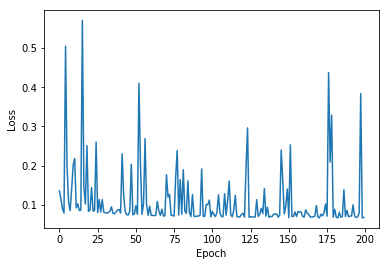

In [11]:
from sklearn.utils import shuffle

cost_arr = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            to, cost = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
            
        #validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH; {:.3f}; Loss; {:.5f}".format(i+1, cost))
        cost_arr.append(cost)
      
        
    saver.save(sess, './lenet')
    print("Model saved")


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
plt.plot(cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [6]:

with tf.Session() as sess:
    saver.Saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_train_processed, y_train)
    print("Train Accuracy = {:.3f}".format(test_accuracy))



TypeError: restore() missing 1 required positional argument: 'save_path'

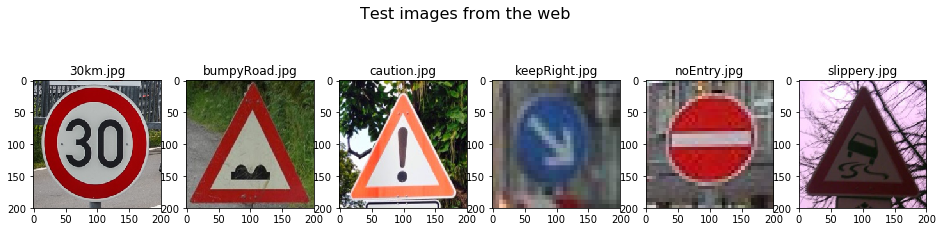

In [15]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

img_folder = 'D:/Tai-Lieu-Hoc-Tap/Nghien-cuu-xu-li-anh/Final/CarND-Traffic-Sign-Classifier-P2-master/examples/'
test_images = []
test_responses = [1, 22, 18, 38, 17, 23]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from the web', fontsize=16)


cnt = 0
for img_name in os.listdir(img_folder):
    image = mpimg.imread(img_folder+img_name)
    image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    cnt = cnt+1
    sub=plt.subplot(1,6,cnt)
    sub.set_title(img_name)
    plt.imshow(image_to_show)
    image = preprocess_image(image) 
    test_images.append(image)
    
    
test_images = np.array(test_images)

In [17]:
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x:  test_images, y: test_responses})
    
print("Predicted Labels")
print(pred_val_out)
print()


with open('D:/Tai-Lieu-Hoc-Tap/Nghien-cuu-xu-li-anh/Final/CarND-Traffic-Sign-Classifier-P2-master/signnames.csv') as csvfile:
    next(csvfile) # ignore header
    a = [ row.strip().split(',') for row in csvfile]
    signnames_dict = dict((data[0],data[1:]) for data in a)
    
cnt = 0
correct_cnt = 0
for i in pred_val_out:
    correctness = "Correct"
    if test_responses[cnt] == i:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
      
    print("{} - {} -> {}".format(i, signnames_dict[str(i)], correctness))
    cnt = cnt + 1

INFO:tensorflow:Restoring parameters from .\lenet
Predicted Labels
[ 1 22 18 38 17 23]

1 - ['Speed limit (30km/h)'] -> Correct
22 - ['Bumpy road'] -> Correct
18 - ['General caution'] -> Correct
38 - ['Keep right'] -> Correct
17 - ['No entry'] -> Correct
23 - ['Slippery road'] -> Correct


In [18]:
print("Accuracy for the tested images equals: {:.2f} %".format(correct_cnt/cnt*100))

Accuracy for the tested images equals: 100.00 %


Top 5 softmax probabilities for fach test image
TopKV2(values=array([[  4.50813740e-01,   3.07346761e-01,   2.25300387e-01,
          1.46928588e-02,   6.39017962e-04],
       [  9.99999762e-01,   2.04216846e-07,   2.46273783e-11,
          1.25649502e-12,   8.38343501e-13],
       [  1.00000000e+00,   1.30878893e-11,   3.17824673e-12,
          2.86034027e-13,   1.06614495e-14],
       [  1.00000000e+00,   4.20053464e-10,   7.37734041e-11,
          1.04115536e-11,   9.25845663e-13],
       [  1.00000000e+00,   1.88890986e-11,   1.93407725e-14,
          6.42356922e-15,   1.07274460e-16],
       [  9.99997377e-01,   1.12524958e-06,   1.08499921e-06,
          3.47637922e-07,   4.40366037e-08]], dtype=float32), indices=array([[ 1,  5, 14,  2, 38],
       [22, 31, 30, 29, 26],
       [18, 27, 28, 26, 37],
       [38, 39, 13,  5, 34],
       [17,  9, 34, 14, 35],
       [23, 10, 21, 30, 19]]))


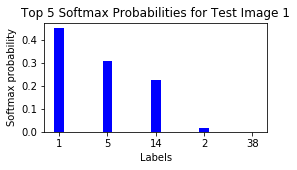

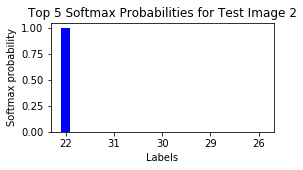

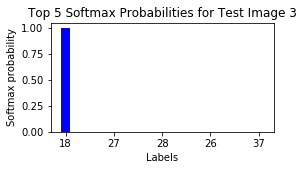

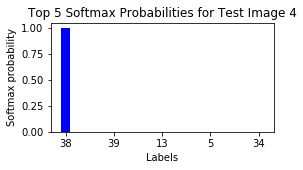

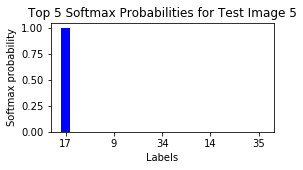

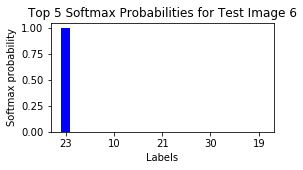

In [19]:
print('Top 5 softmax probabilities for fach test image')
print(pred_topFive_out)

top_k_values = pred_topFive_out[0]
top_k_indices = pred_topFive_out[1]

ind = np.arange(5) 

for i in range(6):
    plt.figure(figsize=(4,2))
    values = top_k_values[i]
    plt.bar(ind, values, 0.2, color='b')
    plt.ylabel('Softmax probability')
    plt.xlabel('Labels')
    plt.title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    plt.xticks(ind, tuple(top_k_indices[i]))

plt.show()